# Statistical and Machine Learning Analysis

This notebook contains the final statistical and ML analysis investigating the relationship between the T cell data and antibody response. 

In [1]:
# Imports & setup
import os

import numpy as np

import re

import pandas as pd
from pandas import read_csv

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.text as mtext
CB_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', 
                  '#e41a1c', '#dede00']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import scipy.stats as stats
from pingouin import multivariate_ttest

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, SparsePCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (balanced_accuracy_score, r2_score, confusion_matrix, recall_score, 
                             roc_auc_score, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence

import xgboost as xgb

import networkx as nx

from data_loader import construct_tcell_df, construct_mfi_df
from bootstrap_utils import (run_repeated_CV_XGB, boot_train_test_XGB, boot_train_test_LR, boot_train_test_random, 
                             boot_train_test_feature, boot_feature_selection, boot_feature_selection_LR, 
                             boot_train_test_XGB_trt_vs_ab)
from misc_utils import print_perf_statistics
from plotting_utils import parcoord_plot, plot_errorbars, parcoord_plot_sep, plotting_setup
from upsetplot import plot as plot_upset
from upsetplot import UpSet
from upsetplot import from_contents, from_memberships, from_indicators

/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# Some extra performance metrics
sensitivity = recall_score


def specificity(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 2 - recall_score(y_true, y_pred)

In [3]:
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, usetex=False, **self.text_props)
        handlebox.add_artist(title)
        return title

In [4]:
# Load raw data
df = read_csv(filepath_or_buffer="data/CoV-ETH_data.csv", low_memory=False)

# Inclusion criteria: 
included = np.ones((df.shape[0], )) == 1

df_included = df.loc[np.squeeze(np.argwhere(included)),]

# Exclude patients with an RBD-only response from the analysis
RBD_only_S10 = np.logical_and(df_included['RBD_IgG_S10'].values >= 50, 
                              np.logical_not(np.logical_or(df_included['N_IgG_S10'].values >= 5.0, 
                                                           np.logical_or(df_included['S1_IgG_S10'].values >=20, 
                                                                    df_included['S2_IgG_S10'].values >= 5.0))))
RBD_only_S11 = np.logical_and(df_included['RBD_IgG_S11'].values >= 50, 
                              np.logical_not(np.logical_or(df_included['N_IgG_S11'].values >= 5.0, 
                                                           np.logical_or(df_included['S1_IgG_S11'].values >= 20, 
                                                                    df_included['S2_IgG_S11'].values >= 5.0))))
RBD_only = np.logical_and(RBD_only_S10, RBD_only_S11)
df_included = df_included.iloc[np.squeeze(np.argwhere(np.logical_not(RBD_only))),]

### Defining Compound Antibody Response

In [5]:
compound_response_S10 = np.logical_and(df_included['RBD_IgG_S10'].values >= 50, 
                                       np.logical_or(df_included['N_IgG_S10'].values >= 5.0, 
                                                     np.logical_or(df_included['S1_IgG_S10'].values >= 20, 
                                                                   df_included['S2_IgG_S10'].values >= 5.0)))
compound_response_S11 = np.logical_and(df_included['RBD_IgG_S11'].values >= 50, 
                                       np.logical_or(df_included['N_IgG_S11'].values >= 5.0, 
                                                     np.logical_or(df_included['S1_IgG_S11'].values >= 20, 
                                                                   df_included['S2_IgG_S11'].values >= 5.0)))
compound_response_ = np.logical_or(compound_response_S10, compound_response_S11)
compound_response = np.copy(compound_response_).astype('U32')
compound_response[compound_response_] = 'positive'
compound_response[np.logical_not(compound_response_)] = 'negative'

In [6]:
# Frequencies & percentages of different response categories
unique, counts = np.unique(compound_response, return_counts=True)
print(unique)
print(counts)
print(counts / np.sum(counts) * 100.0)

['negative' 'positive']
[69 65]
[51.49253731 48.50746269]


### Visualising Antibody Responses

In [7]:
# Based on Susanne's feedback
# RBD response 
rbd_response_s10 = df_included['RBD_IgG_S10'].values >= 50
rbd_response_s11 = df_included['RBD_IgG_S11'].values >= 50
rbd_response = np.copy(rbd_response_s10).astype('U32')
rbd_response[:] = "negative"
rbd_response[np.logical_or(rbd_response_s10 == True, rbd_response_s11 == True)] = 'positive'

# N response
n_response_s10 = df_included['N_IgG_S10'].values >= 5
n_response_s11 = df_included['N_IgG_S11'].values >= 5
n_response = np.copy(n_response_s10).astype('U32')
n_response[:] = "negative"
n_response[np.logical_or(n_response_s10 == True, n_response_s11 == True)] = 'positive'

# S1 response
s1_response_s10 = df_included['S1_IgG_S10'].values >= 20
s1_response_s11 = df_included['S1_IgG_S11'].values >= 20
s1_response = np.copy(s1_response_s10).astype('U32')
s1_response[:] = "negative"
s1_response[np.logical_or(s1_response_s10 == True, s1_response_s11 == True)] = 'positive'

# S2 response 
s2_response_s10 = df_included['S2_IgG_S10'].values >= 5
s2_response_s11 = df_included['S2_IgG_S11'].values >= 5
s2_response = np.copy(s2_response_s10).astype('U32')
s2_response[:] = "negative"
s2_response[np.logical_or(s2_response_s10 == True, s2_response_s11 == True)] = 'positive'

# nAB response 
nab_response_s10 = df_included['nAb_S10'].values >= 20
nab_response_s11 = df_included['nAb_S11'].values >= 20
nab_response = np.copy(nab_response_s10).astype('U32')
nab_response[:] = "negative"
nab_response[np.logical_or(nab_response_s10 == True, nab_response_s11 == True)] = 'positive'

# Save all responses alongside IDs in an excel file
compound_response_bin = np.zeros((compound_response.shape[0], )).astype(float)
compound_response_bin[compound_response == 'positive'] = 1
compound_response_bin[compound_response == 'negative'] = 0

rbd_response_bin = np.zeros((rbd_response.shape[0], )).astype(float)
rbd_response_bin[rbd_response == 'positive'] = 1
rbd_response_bin[rbd_response == 'negative'] = 0

n_response_bin = np.zeros((n_response.shape[0], )).astype(float)
n_response_bin[n_response == 'positive'] = 1
n_response_bin[n_response == 'negative'] = 0

s1_response_bin = np.zeros((s1_response.shape[0], )).astype(float)
s1_response_bin[s1_response == 'positive'] = 1
s1_response_bin[s1_response == 'negative'] = 0


s2_response_bin = np.zeros((s2_response.shape[0], )).astype(float)
s2_response_bin[s2_response == 'positive'] = 1
s2_response_bin[s2_response == 'negative'] = 0

nab_response_bin = np.zeros((nab_response.shape[0], )).astype(float)
nab_response_bin[nab_response == 'positive'] = 1
nab_response_bin[nab_response == 'negative'] = 0

all_responses = np.stack((compound_response_bin, 
                         rbd_response_bin,
                         n_response_bin,
                         s1_response_bin,
                         s2_response_bin,
                         nab_response_bin), axis=1)

ids = df_included['ID'].values.astype(str)

all_responses_dict = {'ID': ids,
                      'Compound': all_responses[:, 0], 'RB': all_responses[:, 1],  
                      'N': all_responses[:, 2], 'S1': all_responses[:, 3], 'S2': all_responses[:, 4], 
                      'nAb': all_responses[:, 5]}
all_responses_df = pd.DataFrame(data=all_responses_dict)

all_responses_df.to_excel('./results/all_responses.xlsx', index=False)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


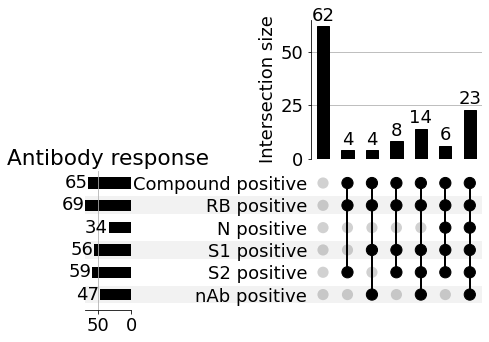

In [8]:
# Visualise intersections for positive groups
plotting_setup(18)

fig = plt.figure(figsize=(15, 20))

all_responses_dict = {'nAb positive': all_responses[all_responses[:, 0] != 999, 5].astype(bool), 
                      'S2 positive': all_responses[all_responses[:, 0] != 999, 4].astype(bool), 
                      'S1 positive': all_responses[all_responses[:, 0] != 999, 3].astype(bool), 
                      'N positive': all_responses[all_responses[:, 0] != 999, 2].astype(bool),
                      'RB positive': all_responses[all_responses[:, 0] != 999, 1].astype(bool), 
                      'Compound positive': all_responses[all_responses[:, 0] != 999, 0].astype(bool)}
all_responses_df = pd.DataFrame(data=all_responses_dict, dtype="bool")
_ = UpSet(from_indicators(lambda all_responses_df: all_responses_df.select_dtypes(bool),
                            data=all_responses_df), min_subset_size=4, show_counts=True, 
          sort_categories_by=None).plot(fig=fig)
_['totals'].set_title('Antibody response')

plt.savefig(fname="figures/upset_positives.svg", dpi=300,  bbox_inches="tight")
plt.savefig(fname="figures/upset_positives.pdf", dpi=300,  bbox_inches="tight")

## Exploratory Analysis: Principal Component Analysis

In [9]:
# Percentage data
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', scale=True)

In [10]:
# Data point labels defined based on compound response
cls = np.copy(compound_response)
cls[compound_response == 'positive'] = 'tab:orange'
cls[compound_response == 'negative'] = 'tab:blue'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


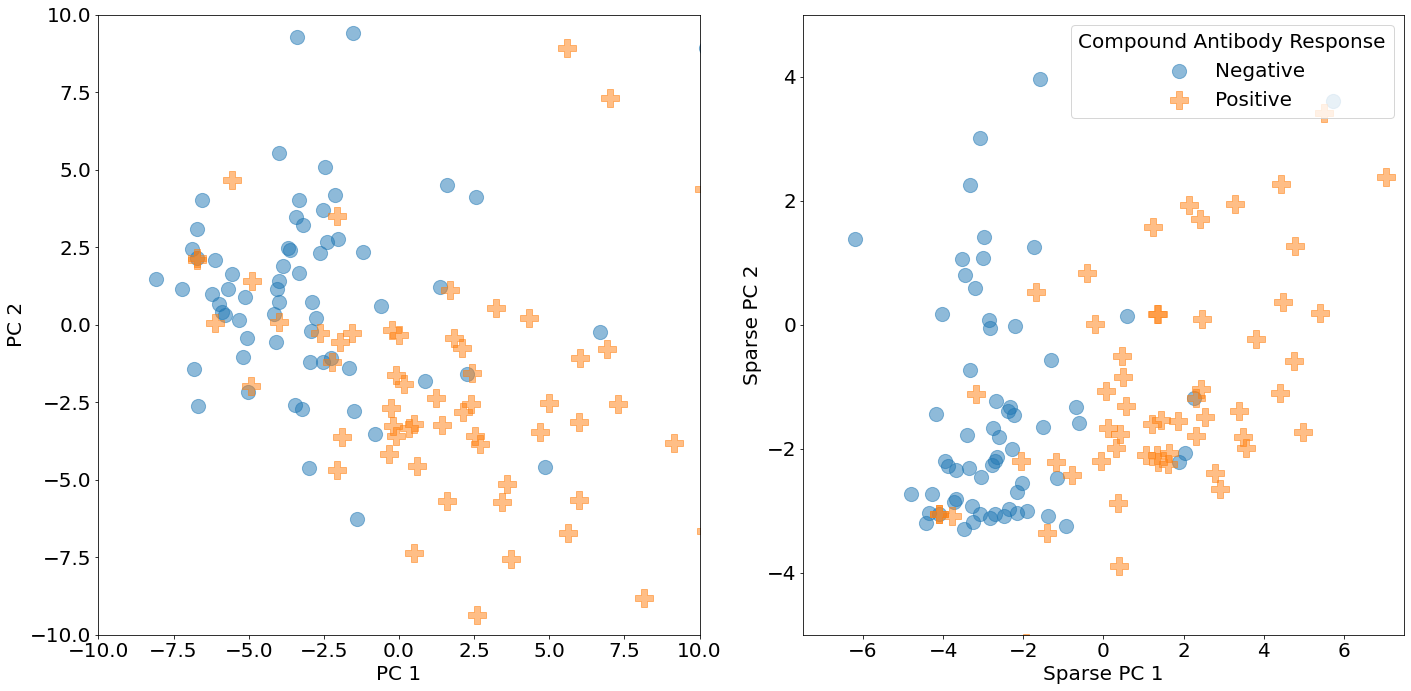

In [11]:
# PCA vs. compound response
plotting_setup(20)

xlim = [-10, 10]
ylim = [-10, 10]

pcs = PCA(n_components=2, random_state=42)
pca = pcs.fit_transform(df_tcell_p)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].scatter(pca[cls == 'tab:blue', 0], pca[cls == 'tab:blue', 1], c='tab:blue', s=200, 
            alpha=0.5, label='Negative', marker='o')
ax[0].scatter(pca[cls == 'tab:orange', 0], pca[cls == 'tab:orange', 1], c='tab:orange', s=300, 
            alpha=0.5, label='Positive', marker='P')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_xlabel("PC 1")
ax[0].set_ylabel("PC 2")


# Sparse PCA vs. compound response
xlim = [-7.5, 7.5]
ylim = [-5, 5]

pcs = SparsePCA(n_components=2, random_state=42, alpha=5)
pca = pcs.fit_transform(df_tcell_p)

ax[1].scatter(pca[cls == 'tab:blue', 0], pca[cls == 'tab:blue', 1], c='tab:blue', s=200, 
            alpha=0.5, label='Negative', marker='o')
ax[1].scatter(pca[cls == 'tab:orange', 0], pca[cls == 'tab:orange', 1], c='tab:orange', s=300, 
            alpha=0.5, label='Positive', marker='P')

ax[1].legend(title='Compound Antibody Response', loc='upper right')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_xlabel("Sparse PC 1")
ax[1].set_ylabel("Sparse PC 2")

plt.tight_layout()
plt.savefig(fname="figures/pca_combo.svg", dpi=300)
plt.savefig(fname="figures/pca_combo.pdf", dpi=300)

In [12]:
# Using the Hotelling's T-squared test, compare PCA embeddings of the two groups
# Vanilla PCA
pcs = PCA(n_components=2, random_state=42)
pca = pcs.fit_transform(df_tcell_p)
multivariate_ttest(pca[cls == 'tab:blue', :], pca[cls == 'tab:orange', :], paired=False)

,T2,F,df1,df2,pval
hotelling,59.540704,29.544819,2,131,2.567390e-11


In [13]:
# Sparse PCA
pcs = SparsePCA(n_components=2, random_state=42, alpha=5)
pca = pcs.fit_transform(df_tcell_p)
multivariate_ttest(pca[cls == 'tab:blue', :], pca[cls == 'tab:orange', :], paired=False)

,T2,F,df1,df2,pval
hotelling,37.878007,18.795526,2,131,6.662063e-08


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


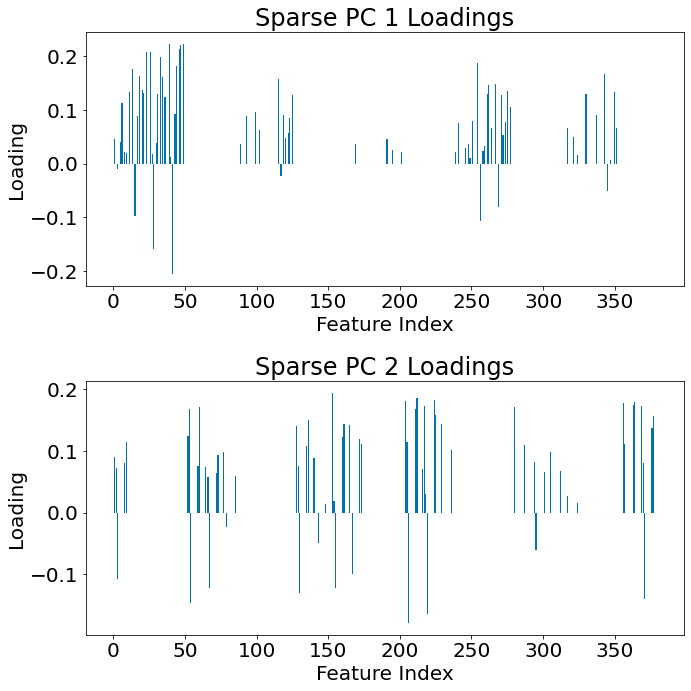

In [14]:
# Sparse PCA loadings

# Visualise sparse PC loadings
pc_loadings = pcs.components_.T

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].bar(x=np.arange(0, pc_loadings.shape[0]), height=pc_loadings[:, 0])
ax[0].set_title('Sparse PC 1 Loadings')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Loading')

ax[1].bar(x=np.arange(0, pc_loadings.shape[0]), height=pc_loadings[:, 1])
ax[1].set_title('Sparse PC 2 Loadings')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Loading')

plt.tight_layout()

In [15]:
# Important features in sparse PC 1
print(feature_names_p[np.abs(pc_loadings[:, 0]) > 0])

['CD3.IFN_pos_TNF_pos_perc_2_S10' 'CD3.IFN_neg_TNF_neg_perc_2_S10'
 'CD3.IL2_pos_CD154_pos_perc_2_S10' 'CD3.IL2_neg_CD154_pos_perc_2_S10'
 'CD3.IFN_pos_perc_2_S10' 'CD3.TNF_pos_perc_2_S10'
 'CD3.CD154_pos_perc_2_S10' 'CD3.IFN_pos_TNF_pos_perc_2_S11'
 'CD3.IFN_neg_TNF_neg_perc_2_S11' 'CD3.IL2_pos_CD154_pos_perc_2_S11'
 'CD3.IL2_neg_CD154_pos_perc_2_S11' 'CD3.IFN_pos_perc_2_S11'
 'CD3.TNF_pos_perc_2_S11' 'CD3.CD154_pos_perc_2_S11'
 'CD4.IFN_pos_TNF_pos_perc_2_S10' 'CD4.IFN_neg_TNF_pos_perc_2_S10'
 'CD4.IFN_neg_TNF_neg_perc_2_S10' 'CD4.IL2_pos_CD154_pos_perc_2_S10'
 'CD4.IL2_neg_CD154_pos_perc_2_S10' 'CD4.IFN_pos_perc_2_S10'
 'CD4.TNF_pos_perc_2_S10' 'CD4.CD154_pos_perc_2_S10'
 'CD4.IFN_pos_TNF_pos_perc_2_S11' 'CD4.IFN_neg_TNF_pos_perc_2_S11'
 'CD4.IFN_neg_TNF_neg_perc_2_S11' 'CD4.IL2_pos_CD154_pos_perc_2_S11'
 'CD4.IL2_neg_CD154_pos_perc_2_S11' 'CD4.IFN_pos_perc_2_S11'
 'CD4.TNF_pos_perc_2_S11' 'CD4.CD154_pos_perc_2_S11'
 'CD3.IFN_pos_TNF_pos_perc_3_S11' 'CD3.IL2_pos_CD154_pos_perc_3_S11

In [16]:
# Important features in sparse PC 1
print(feature_names_p[np.abs(pc_loadings[:, 1]) > 0])

['CD3.IFN_pos_TNF_pos_perc_2_S10' 'CD3.IFN_neg_TNF_pos_perc_2_S10'
 'CD3.IFN_neg_TNF_neg_perc_2_S10' 'CD3.IFN_pos_perc_2_S10'
 'CD3.TNF_pos_perc_2_S10' 'CD8.IFN_pos_TNF_pos_perc_2_S10'
 'CD8.IFN_neg_TNF_pos_perc_2_S10' 'CD8.IFN_neg_TNF_neg_perc_2_S10'
 'CD8.IFN_pos_perc_2_S10' 'CD8.TNF_pos_perc_2_S10'
 'CD8.IFN_pos_TNF_neg_perc_2_S11' 'CD8.IFN_neg_TNF_pos_perc_2_S11'
 'CD8.IFN_neg_TNF_neg_perc_2_S11' 'CD8.IFN_pos_perc_2_S11'
 'CD8.TNF_pos_perc_2_S11' 'CD3.IFN_pos_TNF_pos_perc_3_S10'
 'CD3.IFN_neg_TNF_neg_perc_3_S10' 'CD3.TNF_pos_perc_3_S10'
 'CD8.IFN_pos_TNF_pos_perc_3_S10' 'CD8.IFN_neg_TNF_pos_perc_3_S10'
 'CD8.IFN_neg_TNF_neg_perc_3_S10' 'CD8.IFN_pos_perc_3_S10'
 'CD8.TNF_pos_perc_3_S10' 'CD8.IFN_pos_TNF_neg_perc_3_S11'
 'CD8.IFN_neg_TNF_neg_perc_3_S11' 'CD8.IFN_pos_perc_3_S11'
 'CD3.IFN_pos_TNF_pos_perc_4_S10' 'CD3.IFN_neg_TNF_pos_perc_4_S10'
 'CD3.IFN_neg_TNF_neg_perc_4_S10' 'CD3.IFN_pos_perc_4_S10'
 'CD3.TNF_pos_perc_4_S10' 'CD3.IFN_pos_TNF_pos_perc_4_S11'
 'CD3.IFN_neg_TNF_neg_pe

## Predicting Antibody Response Using T-cell Measurements

   ### Counts

In [17]:
# Count data: logistic regression
if os.path.isfile('results/metrics_clf_counts_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_counts_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_counts_cons_lr.csv'):
    metrics_clf_c_lr = np.loadtxt(fname="results/metrics_clf_counts_cons_lr.csv", delimiter=",")
    metrics_proba_c_lr = np.loadtxt(fname="results/metrics_proba_counts_cons_lr.csv", delimiter=",")
    feature_importances_c_lr = np.loadtxt(fname="results/feat_imps_counts_cons_lr.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    disease_status = compound_response
    disease_status = ((disease_status == 'positive') * 1.).astype(int)

    metrics_clf_c_lr, metrics_proba_c_lr, feature_importances_c_lr = boot_train_test_LR(
        X=df_tcell_c, y=disease_status, 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_counts_cons_lr.csv", X=metrics_clf_c_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_counts_cons_lr.csv", X=metrics_proba_c_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_counts_cons_lr.csv", X=feature_importances_c_lr, delimiter=",")

In [18]:
print_perf_statistics(metrics_clf_c_lr, alpha=0.05)

0.833; [0.619, 1.0]
0.82; [0.454, 1.0]
0.846; [0.5, 1.0]


In [19]:
print_perf_statistics(metrics_proba_c_lr, alpha=0.05)

0.92; [0.729, 1.0]
0.927; [0.741, 1.0]


In [20]:
# Count data: XGBoost
if os.path.isfile('results/metrics_clf_counts_cons.csv') and \
   os.path.isfile('results/metrics_proba_counts_cons.csv') and \
   os.path.isfile('results/feat_imps_counts_cons.csv'):
    metrics_clf_c = np.loadtxt(fname="results/metrics_clf_counts_cons.csv", delimiter=",")
    metrics_proba_c = np.loadtxt(fname="results/metrics_proba_counts_cons.csv", delimiter=",")
    feature_importances_c = np.loadtxt(fname="results/feat_imps_counts_cons.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    disease_status = compound_response
    disease_status = ((disease_status == 'positive') * 1.).astype(int)

    metrics_clf_c, metrics_proba_c, feature_importances_c = boot_train_test_XGB(
        X=df_tcell_c, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_counts_cons.csv", X=metrics_clf_c, delimiter=",")
    np.savetxt(fname="results/metrics_proba_counts_cons.csv", X=metrics_proba_c, delimiter=",")
    np.savetxt(fname="results/feat_imps_counts_cons.csv", X=feature_importances_c, delimiter=",")

In [21]:
print_perf_statistics(metrics_clf_c, alpha=0.05)

0.904; [0.723, 1.0]
0.887; [0.562, 1.0]
0.921; [0.667, 1.0]


In [22]:
print_perf_statistics(metrics_proba_c, alpha=0.05)

0.959; [0.8, 1.0]
0.963; [0.812, 1.0]


### Percentages

In [23]:
# Percentage data: logistic regression
if os.path.isfile('results/metrics_clf_percs_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_percs_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_percs_cons_lr.csv'):
    metrics_clf_p_lr = np.loadtxt(fname="results/metrics_clf_percs_cons_lr.csv", delimiter=",")
    metrics_proba_p_lr = np.loadtxt(fname="results/metrics_proba_percs_cons_lr.csv", delimiter=",")
    feature_importances_p_lr = np.loadtxt(fname="results/feat_imps_percs_cons_lr.csv", delimiter=",")
else:
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_p_lr, metrics_proba_p_lr, feature_importances_p_lr = boot_train_test_LR(
        X=df_tcell_p, y=disease_status, 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_percs_cons_lr.csv", X=metrics_clf_p_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_percs_cons_lr.csv", X=metrics_proba_p_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_percs_cons_lr.csv", X=feature_importances_p_lr, delimiter=",")

In [24]:
print_perf_statistics(metrics_clf_p_lr, alpha=0.05)

0.836; [0.597, 1.0]
0.856; [0.545, 1.0]
0.817; [0.444, 1.0]


In [25]:
print_perf_statistics(metrics_proba_p_lr, alpha=0.05)

0.908; [0.688, 1.0]
0.919; [0.705, 1.0]


In [26]:
# Percentage data: XGBoost
if os.path.isfile('results/metrics_clf_percs_cons.csv') and \
   os.path.isfile('results/metrics_proba_percs_cons.csv') and \
   os.path.isfile('results/feat_imps_percs_cons.csv'):
    metrics_clf_p = np.loadtxt(fname="results/metrics_clf_percs_cons.csv", delimiter=",")
    metrics_proba_p = np.loadtxt(fname="results/metrics_proba_percs_cons.csv", delimiter=",")
    feature_importances_p = np.loadtxt(fname="results/feat_imps_percs_cons.csv", delimiter=",")
else:
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_p, metrics_proba_p, feature_importances_p = boot_train_test_XGB(
        X=df_tcell_p, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=True)
    np.savetxt(fname="results/metrics_clf_percs_cons.csv", X=metrics_clf_p, delimiter=",")
    np.savetxt(fname="results/metrics_proba_percs_cons.csv", X=metrics_proba_p, delimiter=",")
    np.savetxt(fname="results/feat_imps_percs_cons.csv", X=feature_importances_p, delimiter=",")

In [27]:
print_perf_statistics(metrics_clf_p, alpha=0.05)

0.895; [0.702, 1.0]
0.886; [0.571, 1.0]
0.905; [0.615, 1.0]


In [28]:
print_perf_statistics(metrics_proba_p, alpha=0.05)

0.951; [0.762, 1.0]
0.954; [0.75, 1.0]


### Counts & Percentages

In [29]:
# Count + percentage data: logistic regression
if os.path.isfile('results/metrics_clf_pc_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_pc_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_pc_cons_lr.csv'):
    metrics_clf_pc_lr = np.loadtxt(fname="results/metrics_clf_pc_cons_lr.csv", delimiter=",")
    metrics_proba_pc_lr = np.loadtxt(fname="results/metrics_proba_pc_cons_lr.csv", delimiter=",")
    feature_importances_pc_lr = np.loadtxt(fname="results/feat_imps_pc_cons_lr.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
    feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_pc_lr, metrics_proba_pc_lr, feature_importances_pc_lr = boot_train_test_LR(
        X=df_tcell_pc, y=disease_status, 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_pc_cons_lr.csv", X=metrics_clf_pc_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_pc_cons_lr.csv", X=metrics_proba_pc_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_pc_cons_lr.csv", X=feature_importances_pc_lr, delimiter=",")

In [30]:
print_perf_statistics(metrics_clf_pc_lr, alpha=0.05)

0.872; [0.688, 1.0]
0.838; [0.5, 1.0]
0.906; [0.667, 1.0]


In [31]:
print_perf_statistics(metrics_proba_pc_lr, alpha=0.05)

0.945; [0.786, 1.0]
0.949; [0.771, 1.0]


In [32]:
# Count + percentage data: XGBoost
if os.path.isfile('results/metrics_clf_pc_cons.csv') and \
   os.path.isfile('results/metrics_proba_pc_cons.csv') and \
   os.path.isfile('results/feat_imps_pc_cons.csv'):
    metrics_clf_pc = np.loadtxt(fname="results/metrics_clf_pc_cons.csv", delimiter=",")
    metrics_proba_pc = np.loadtxt(fname="results/metrics_proba_pc_cons.csv", delimiter=",")
    feature_importances_pc = np.loadtxt(fname="results/feat_imps_pc_cons.csv", delimiter=",")
else:
    df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
    feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_pc, metrics_proba_pc, feature_importances_pc = boot_train_test_XGB(
        X=df_tcell_pc, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000,)
    np.savetxt(fname="results/metrics_clf_pc_cons.csv", X=metrics_clf_pc, delimiter=",")
    np.savetxt(fname="results/metrics_proba_pc_cons.csv", X=metrics_proba_pc, delimiter=",")
    np.savetxt(fname="results/feat_imps_pc_cons.csv", X=feature_importances_pc, delimiter=",")

In [33]:
print_perf_statistics(metrics_clf_pc, alpha=0.05)

0.903; [0.7, 1.0]
0.884; [0.545, 1.0]
0.921; [0.666, 1.0]


In [34]:
print_perf_statistics(metrics_proba_pc, alpha=0.05)

0.956; [0.799, 1.0]
0.959; [0.764, 1.0]


### MFIs

In [35]:
# MFI data: LR
if os.path.isfile('results/metrics_clf_mfi_cons_lr.csv') and \
   os.path.isfile('results/metrics_proba_mfi_cons_lr.csv') and \
   os.path.isfile('results/feat_imps_mfi_cons_lr.csv'):
    metrics_clf_mfi_lr = np.loadtxt(fname="results/metrics_clf_mfi_cons_lr.csv", delimiter=",")
    metrics_proba_mfi_lr = np.loadtxt(fname="results/metrics_proba_mfi_cons_lr.csv", delimiter=",")
    feature_importances_mfi_lr = np.loadtxt(fname="results/feat_imps_mfi_cons_lr.csv", delimiter=",")
else:
    df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included)
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_mfi_lr, metrics_proba_mfi_lr, feature_importances_mfi_lr = boot_train_test_LR(
        X=df_tcell_mfi, y=disease_status, 
        metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_mfi_cons_lr.csv", X=metrics_clf_mfi_lr, delimiter=",")
    np.savetxt(fname="results/metrics_proba_mfi_cons_lr.csv", X=metrics_proba_mfi_lr, delimiter=",")
    np.savetxt(fname="results/feat_imps_mfi_cons_lr.csv", X=feature_importances_mfi_lr, delimiter=",")

In [36]:
print_perf_statistics(metrics_clf_mfi_lr, alpha=0.05)

0.79; [0.558, 0.971]
0.773; [0.4, 1.0]
0.806; [0.444, 1.0]


In [37]:
print_perf_statistics(metrics_proba_mfi_lr, alpha=0.05)

0.871; [0.636, 1.0]
0.881; [0.61, 1.0]


In [38]:
# MFI data: XGBoost
if os.path.isfile('results/metrics_clf_mfi_cons.csv') and \
   os.path.isfile('results/metrics_proba_mfi_cons.csv') and \
   os.path.isfile('results/feat_imps_mfi_cons.csv'):
    metrics_clf_mfi = np.loadtxt(fname="results/metrics_clf_mfi_cons.csv", delimiter=",")
    metrics_proba_mfi = np.loadtxt(fname="results/metrics_proba_mfi_cons.csv", delimiter=",")
    feature_importances_mfi = np.loadtxt(fname="results/feat_imps_mfi_cons.csv", delimiter=",")
else:
    df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included)
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_mfi, metrics_proba_mfi, feature_importances_mfi = boot_train_test_XGB(
        X=df_tcell_mfi, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_mfi_cons.csv", X=metrics_clf_mfi, delimiter=",")
    np.savetxt(fname="results/metrics_proba_mfi_cons.csv", X=metrics_proba_mfi, delimiter=",")
    np.savetxt(fname="results/feat_imps_mfi_cons.csv", X=feature_importances_mfi, delimiter=",")

In [39]:
print_perf_statistics(metrics_clf_mfi, alpha=0.05)

0.856; [0.636, 1.0]
0.85; [0.533, 1.0]
0.861; [0.5, 1.0]


In [40]:
print_perf_statistics(metrics_proba_mfi, alpha=0.05)

0.927; [0.731, 1.0]
0.927; [0.689, 1.0]


### Random Guess

In [41]:
# Random guess

if os.path.isfile('results/metrics_clf_cons_rand.csv') and os.path.isfile('results/metrics_proba_cons_rand.csv'):
    metrics_clf_r = np.loadtxt(fname="results/metrics_clf_cons_rand.csv", delimiter=",")
    metrics_proba_r = np.loadtxt(fname="results/metrics_proba_cons_rand.csv", delimiter=",")
else:
    df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc')
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)
    metrics_clf_r, metrics_proba_r = boot_train_test_random(X=df_tcell_p, 
                                                            y=disease_status, 
                                                            metrics_clf=[balanced_accuracy_score, sensitivity, 
                                                                         specificity], 
                                                            metrics_proba=[roc_auc_score, 
                                                                           average_precision_score], 
                                                            B=10000)
    np.savetxt(fname="results/metrics_clf_cons_rand.csv", X=metrics_clf_r, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_rand.csv", X=metrics_proba_r, delimiter=",")

In [42]:
print_perf_statistics(metrics_clf_r, alpha=0.05)

0.499; [0.306, 0.7]
0.485; [0.125, 0.778]
0.514; [0.143, 0.8]


In [43]:
print_perf_statistics(metrics_proba_r, alpha=0.05)

0.499; [0.306, 0.7]
0.496; [0.236, 0.76]


## Examining Important Variables

In [44]:
# Plotting setup
plt.rcParams.update({'font.size': 10})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


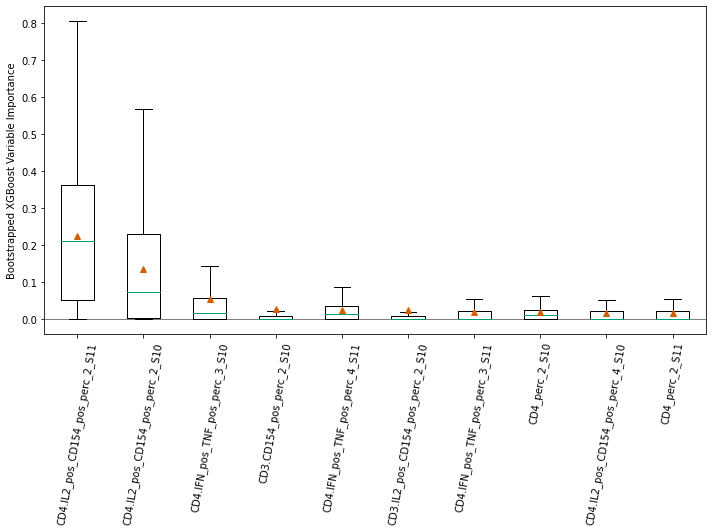

In [45]:
# Top 10 most important features among percentages in the GBM model
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count')
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', scale=True)
mean_feature_importances_p = np.mean(feature_importances_p, axis=0)
feature_importance_sd_p = np.std(feature_importances_p, axis=1)
top_10_features_p = feature_names_p[mean_feature_importances_p.argsort()[-10:][::-1]]
top_10_importances_p = feature_importances_p[:, mean_feature_importances_p.argsort()[-10:][::-1]]
fig = plt.figure(figsize=(10,7.5))
ax = plt.gca()
g0 = ax.axhline(c='grey', lw=1)
bx = plt.boxplot(top_10_importances_p, positions=np.arange(0, 10), showmeans=True, showfliers=False,
                labels=top_10_features_p)
xt = plt.xticks(rotation=80)
ylab = plt.ylabel("Bootstrapped XGBoost Variable Importance")
plt.tight_layout()
plt.savefig(fname="figures/xgb_varimp_percs_cons.png", dpi=300)

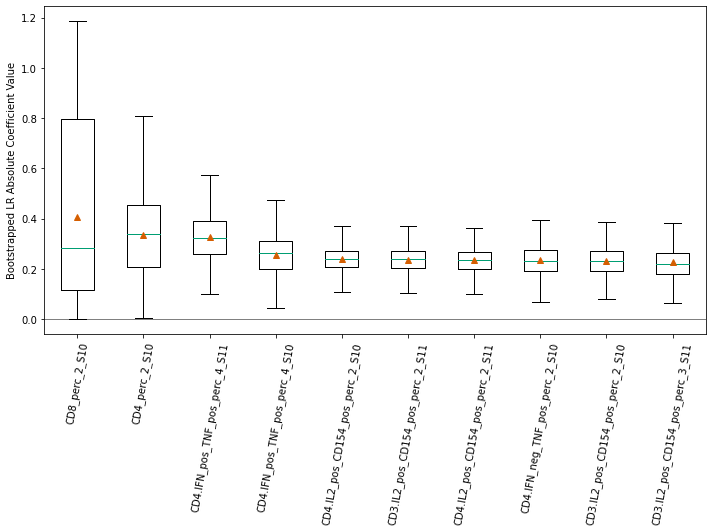

In [46]:
# Top 10 most important features among percentages in the LR model
mean_feature_importances_p_lr = np.mean(feature_importances_p_lr, axis=0)
feature_importance_sd_p_lr = np.std(feature_importances_p_lr, axis=1)
top_10_features_p_lr = feature_names_p[mean_feature_importances_p_lr.argsort()[-10:][::-1]]
top_10_importances_p_lr = feature_importances_p_lr[:, mean_feature_importances_p_lr.argsort()[-10:][::-1]]
fig = plt.figure(figsize=(10,7.5))
ax = plt.gca()
g0 = ax.axhline(c='grey', lw=1)
bx = plt.boxplot(top_10_importances_p_lr, positions=np.arange(0, 10), showmeans=True, showfliers=False,
                labels=top_10_features_p_lr)
xt = plt.xticks(rotation=80)
ylab = plt.ylabel("Bootstrapped LR Absolute Coefficient Value")
plt.tight_layout()
plt.savefig(fname="figures/lr_varimp_percs_cons.png", dpi=300)

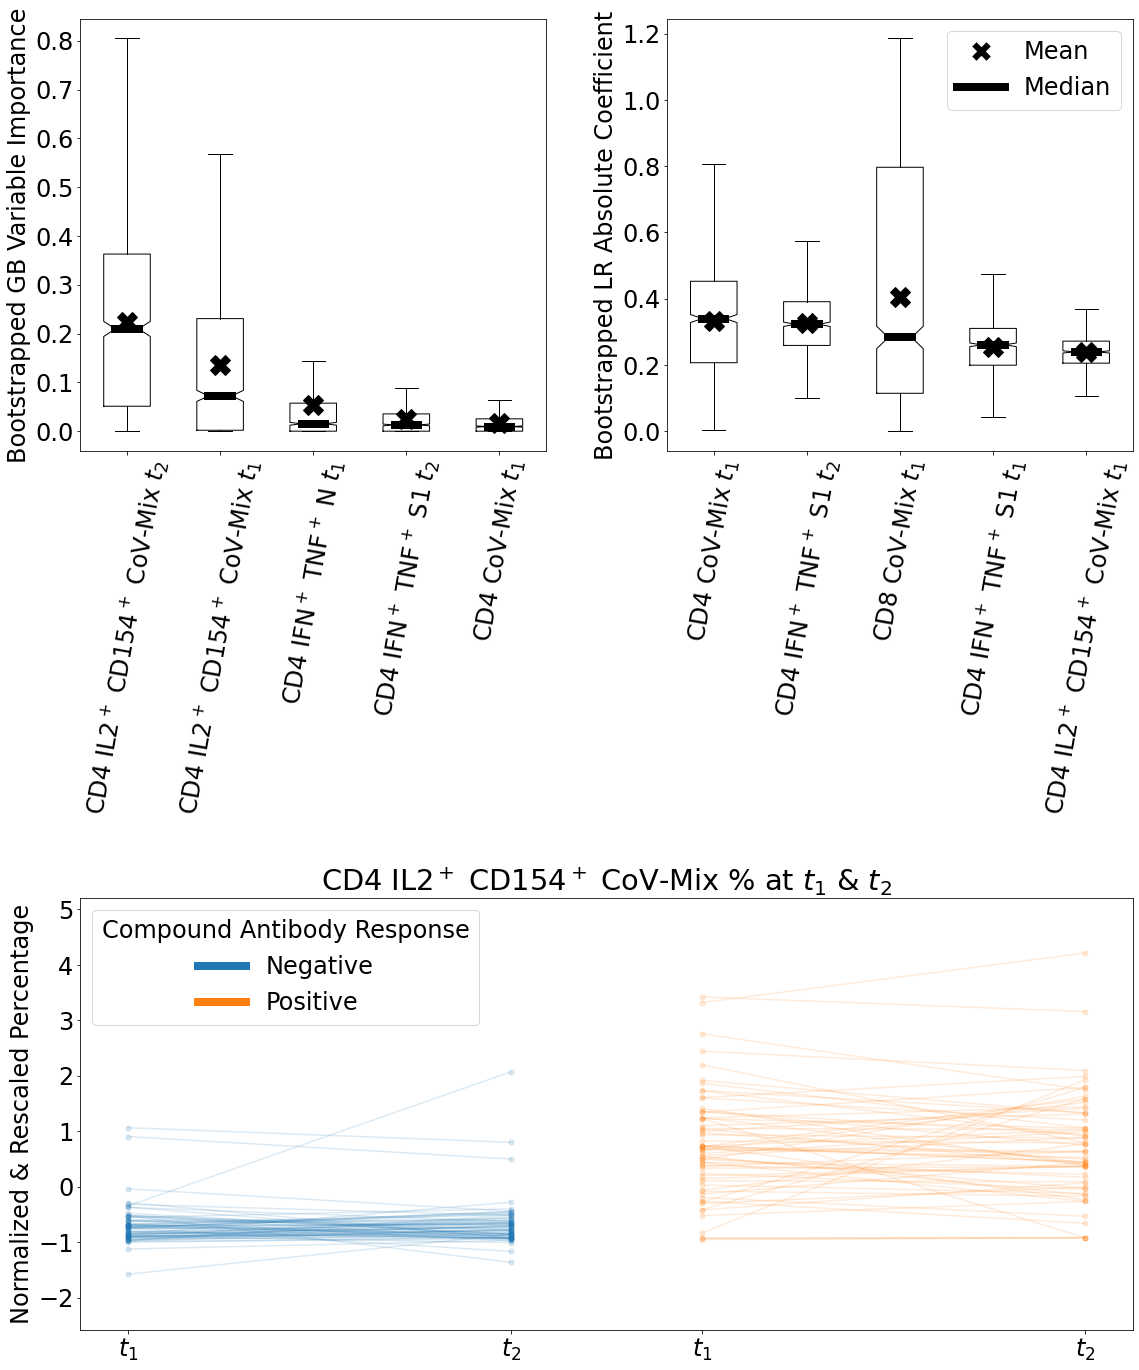

In [48]:
# Importance plot for the final paper
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plotting_setup(24)


# Custom grid layout
plt.figure(figsize=(17, 20))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
ax = [ax1, ax2, ax3]


# XGBoost importances
med_feature_importances_p = np.median(feature_importances_p, axis=0)
feature_importance_sd_p = np.std(feature_importances_p, axis=1)
top_features_p = feature_names_p[med_feature_importances_p.argsort()[-5:][::-1]]
top_importances_p = feature_importances_p[:, med_feature_importances_p.argsort()[-5:][::-1]]

top_features_p = [s.replace('.', ' ').replace('_S10', ' $t_1$').replace('_S11', ' $t_2$').replace(
    '_perc', '').replace('_pos_', '$^+$ ').replace(' 2 ', ' CoV-Mix ').replace(
    ' 3 ', ' N ').replace(' 4 ', ' S1 ').replace('8_2', '8 CoV-Mix').replace(
    '4_2', '4 CoV-Mix') for s in top_features_p]

flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=8, color='black')
meanpointprops = dict(marker='X', markeredgecolor='black',
                      markerfacecolor='black', markersize=20)

bx = ax[0].boxplot(top_importances_p, positions=np.arange(0, 5), showmeans=True, showfliers=False,
                   labels=top_features_p, notch=True, flierprops=flierprops, medianprops=medianprops, 
                   meanprops=meanpointprops)
ylab = ax[0].set_ylabel("Bootstrapped GB Variable Importance")
ax[0].tick_params(axis='x', rotation=80)


# Legend
legend_elements = [Line2D([0], [0], marker='X', color='white', label='Mean', 
                          markerfacecolor='black', markersize=20), 
                   Line2D([0], [0], color='black', lw=8, label='Median')]
ax[1].legend(loc='upper right', handles=legend_elements)


# LR importances
med_feature_importances_p_lr = np.median(feature_importances_p_lr, axis=0)
feature_importance_sd_p_lr = np.std(feature_importances_p_lr, axis=1)
top_features_p_lr = feature_names_p[med_feature_importances_p_lr.argsort()[-5:][::-1]]
top_importances_p_lr = feature_importances_p_lr[:, med_feature_importances_p_lr.argsort()[-5:][::-1]]

top_features_p_lr = [s.replace('.', ' ').replace('_S10', ' $t_1$').replace('_S11', ' $t_2$').replace(
    '_perc', '').replace('_pos_', '$^+$ ').replace('_neg_', '− ').replace(
    ' 2 ', ' CoV-Mix ').replace(' 3 ', ' N ').replace(' 4 ', ' S1 ').replace('8_2', '8 CoV-Mix').replace(
    '4_2', '4 CoV-Mix') for s in top_features_p_lr]

bx = ax[1].boxplot(top_importances_p_lr, positions=np.arange(0, 5), showmeans=True, showfliers=False, 
                   labels=top_features_p_lr, notch=True, flierprops=flierprops, medianprops=medianprops, 
                   meanprops=meanpointprops)
ylab = ax[1].set_ylabel("Bootstrapped LR Absolute Coefficient")
ax[1].tick_params(axis='x', rotation=80)


# Parallel coordinate plot for CD4 IL2+ CD154+ Cov-mix
cls = np.copy(compound_response)
cls[cls == 'positive'] = 'tab:orange'
cls[cls == 'negative'] = 'tab:blue'

x1=df_tcell_p[:, med_feature_importances_p.argsort()[-10:][::-1]][:, 1]
x2=df_tcell_p[:, med_feature_importances_p.argsort()[-10:][::-1]][:, 0]
tick1='$t_1$' 
tick2='$t_2$'
colors=cls
labels={'tab:blue': 'Negative', 'tab:orange': 'Positive'} 

cnt = 1
ticks_x = []
for c in np.unique(colors):
    label_c = labels[c]
    x1_c = x1[colors == c]
    x2_c = x2[colors == c]
    ax[2].scatter(np.ones_like(x1_c) * cnt, x1_c, c=c, label=label_c, s=25, alpha=0.15)
    ax[2].scatter(np.ones_like(x2_c) * (cnt + 1), x2_c, c=c, s=25, alpha=0.15)
    for i in range(len(x1_c)):
        ax[2].plot([cnt, cnt + 1], [x1_c[i], x2_c[i]], c=c, alpha=0.15)
    ticks_x.append(cnt)
    ticks_x.append(cnt + 1)
    cnt = cnt + 1.5
ax[2].set_ylim([min(np.min(x1), np.min(x2)) - 1, max(np.max(x1), np.max(x2)) + 1])
ax[2].set_xticks(ticks=ticks_x)
ax[2].set_xticklabels(labels=[tick1, tick2] * len(np.unique(colors)))
ax[2].set_ylabel("Normalized & Rescaled Percentage")
legend_elements = [Line2D([0], [0], color='tab:blue', lw=8, label='Negative'),
                  Line2D([0], [0], color='tab:orange', lw=8, label='Positive')]
ax[2].legend(loc='upper left', handles=legend_elements, title='Compound Antibody Response')
ax[2].set_title('CD4 IL2$^+$ CD154$^+$ CoV-Mix % at $t_1$ & $t_2$')

plt.tight_layout(pad=2.0)


plt.savefig(fname="figures/xgb_varimp_cons.svg", dpi=300, bbox_inches='tight')
plt.savefig(fname="figures/xgb_varimp_cons.pdf", dpi=300, bbox_inches='tight')

## Comparing T-cell Types

### CD3

In [49]:
if os.path.isfile('results/metrics_clf_cons_cd3.csv') and \
   os.path.isfile('results/metrics_proba_cons_cd3.csv') and \
   os.path.isfile('results/feat_imps_cons_cd3.csv'):
    metrics_clf_cd3 = np.loadtxt(fname="results/metrics_clf_cons_cd3.csv", delimiter=",")
    metrics_proba_cd3 = np.loadtxt(fname="results/metrics_proba_cons_cd3.csv", delimiter=",")
    feature_importances_cd3 = np.loadtxt(fname="results/feat_imps_cons_cd3.csv", delimiter=",")
else:
    df_tcell_cd3, feature_names_cd3 = construct_tcell_df(df_included, feature_type='perc', tcell_types=['CD3'])
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_cd3, metrics_proba_cd3, feature_importances_cd3 = boot_train_test_XGB(
        X=df_tcell_cd3, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_cons_cd3.csv", X=metrics_clf_cd3, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_cd3.csv", X=metrics_proba_cd3, delimiter=",")
    np.savetxt(fname="results/feat_imps_cons_cd3.csv", X=feature_importances_cd3, delimiter=",")

In [50]:
print_perf_statistics(metrics_clf_cd3, alpha=0.05)

0.881; [0.667, 1.0]
0.88; [0.571, 1.0]
0.883; [0.556, 1.0]


In [51]:
print_perf_statistics(metrics_proba_cd3, alpha=0.05)

0.939; [0.743, 1.0]
0.941; [0.722, 1.0]


### CD4

In [52]:
if os.path.isfile('results/metrics_clf_cons_cd4.csv') and \
   os.path.isfile('results/metrics_proba_cons_cd4.csv') and \
   os.path.isfile('results/feat_imps_cons_cd4.csv'):
    metrics_clf_cd4 = np.loadtxt(fname="results/metrics_clf_cons_cd4.csv", delimiter=",")
    metrics_proba_cd4 = np.loadtxt(fname="results/metrics_proba_cons_cd4.csv", delimiter=",")
    feature_importances_cd4 = np.loadtxt(fname="results/feat_imps_cons_cd4.csv", delimiter=",")
else:
    df_tcell_cd4, feature_names_cd4 = construct_tcell_df(df_included, feature_type='perc', tcell_types=['CD4'])
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_cd4, metrics_proba_cd4, feature_importances_cd4 = boot_train_test_XGB(
        X=df_tcell_cd4, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_cons_cd4.csv", X=metrics_clf_cd4, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_cd4.csv", X=metrics_proba_cd4, delimiter=",")
    np.savetxt(fname="results/feat_imps_cons_cd4.csv", X=feature_importances_cd4, delimiter=",")

In [53]:
print_perf_statistics(metrics_clf_cd4, alpha=0.05)

0.901; [0.7, 1.0]
0.894; [0.583, 1.0]
0.909; [0.625, 1.0]


In [54]:
print_perf_statistics(metrics_proba_cd4, alpha=0.05)

0.956; [0.787, 1.0]
0.957; [0.778, 1.0]


### CD8

In [55]:
if os.path.isfile('results/metrics_clf_cons_cd8.csv') and \
   os.path.isfile('results/metrics_proba_cons_cd8.csv') and \
   os.path.isfile('results/feat_imps_cons_cd8.csv'):
    metrics_clf_cd8 = np.loadtxt(fname="results/metrics_clf_cons_cd8.csv", delimiter=",")
    metrics_proba_cd8 = np.loadtxt(fname="results/metrics_proba_cons_cd8.csv", delimiter=",")
    feature_importances_cd8 = np.loadtxt(fname="results/feat_imps_cons_cd8.csv", delimiter=",")
else:
    df_tcell_cd8, feature_names_cd8 = construct_tcell_df(df_included, feature_type='perc', tcell_types=['CD8'])
    disease_status = compound_response
    disease_status = ((disease_status == "positive") * 1.0).astype(int)

    metrics_clf_cd8, metrics_proba_cd8, feature_importances_cd8 = boot_train_test_XGB(
        X=df_tcell_cd8, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
        metrics_proba=[roc_auc_score, average_precision_score], B=1000)
    np.savetxt(fname="results/metrics_clf_cons_cd8.csv", X=metrics_clf_cd8, delimiter=",")
    np.savetxt(fname="results/metrics_proba_cons_cd8.csv", X=metrics_proba_cd8, delimiter=",")
    np.savetxt(fname="results/feat_imps_cons_cd8.csv", X=feature_importances_cd8, delimiter=",")

In [56]:
print_perf_statistics(metrics_clf_cd8, alpha=0.05)

0.516; [0.25, 0.773]
0.523; [0.133, 0.934]
0.51; [0.125, 0.9]


In [57]:
print_perf_statistics(metrics_proba_cd8, alpha=0.05)

0.52; [0.202, 0.828]
0.579; [0.278, 0.874]


## Predicting Different Antibody Type Responses

In [58]:
# Compound
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='cons', df_dir='data/CoV-ETH_data.csv')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='cons', df_dir='data/CoV-ETH_data.csv')

In [59]:
# RBD
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='rbd', df_dir='data/CoV-ETH_data.csv')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='rbd', df_dir='data/CoV-ETH_data.csv')

In [60]:
# N
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='n', df_dir='data/CoV-ETH_data.csv')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='n', df_dir='data/CoV-ETH_data.csv')

In [61]:
# S1
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='s1', df_dir='data/CoV-ETH_data.csv')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='s1', df_dir='data/CoV-ETH_data.csv')

In [62]:
# S2
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='s2', df_dir='data/CoV-ETH_data.csv')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='s2', df_dir='data/CoV-ETH_data.csv')

In [63]:
# nAb
for trt in range(2, 7):
    boot_train_test_XGB_trt_vs_ab(trt=trt, ab='nab', df_dir='data/CoV-ETH_data.csv')
boot_train_test_XGB_trt_vs_ab(trt=-1, ab='nab', df_dir='data/CoV-ETH_data.csv')

### Visualising Results

In [64]:
# Load precomputed metrics
# RBD
metrics_proba_cov2mix_rbd = np.loadtxt(fname="results/metrics_proba_rbd_cov2mix.csv", delimiter=",")
metrics_proba_n_rbd = np.loadtxt(fname="results/metrics_proba_rbd_protn.csv", delimiter=",")
metrics_proba_s1_rbd = np.loadtxt(fname="results/metrics_proba_rbd_prots1.csv", delimiter=",")
metrics_proba_s_rbd = np.loadtxt(fname="results/metrics_proba_rbd_prots.csv", delimiter=",")
metrics_proba_m_rbd = np.loadtxt(fname="results/metrics_proba_rbd_protm.csv", delimiter=",")
metrics_proba_r_rbd = np.loadtxt(fname="results/metrics_proba_rbd_rand.csv", delimiter=",")
# N
metrics_proba_cov2mix_n = np.loadtxt(fname="results/metrics_proba_n_cov2mix.csv", delimiter=",")
metrics_proba_n_n = np.loadtxt(fname="results/metrics_proba_n_protn.csv", delimiter=",")
metrics_proba_s1_n = np.loadtxt(fname="results/metrics_proba_n_prots1.csv", delimiter=",")
metrics_proba_s_n = np.loadtxt(fname="results/metrics_proba_n_prots.csv", delimiter=",")
metrics_proba_m_n = np.loadtxt(fname="results/metrics_proba_n_protm.csv", delimiter=",")
metrics_proba_r_n = np.loadtxt(fname="results/metrics_proba_n_rand.csv", delimiter=",")
# S1
metrics_proba_cov2mix_s1 = np.loadtxt(fname="results/metrics_proba_s1_cov2mix.csv", delimiter=",")
metrics_proba_n_s1 = np.loadtxt(fname="results/metrics_proba_s1_protn.csv", delimiter=",")
metrics_proba_s1_s1 = np.loadtxt(fname="results/metrics_proba_s1_prots1.csv", delimiter=",")
metrics_proba_s_s1 = np.loadtxt(fname="results/metrics_proba_s1_prots.csv", delimiter=",")
metrics_proba_m_s1 = np.loadtxt(fname="results/metrics_proba_s1_protm.csv", delimiter=",")
metrics_proba_r_s1 = np.loadtxt(fname="results/metrics_proba_s1_rand.csv", delimiter=",")
# S2
metrics_proba_cov2mix_s2 = np.loadtxt(fname="results/metrics_proba_s2_cov2mix.csv", delimiter=",")
metrics_proba_n_s2 = np.loadtxt(fname="results/metrics_proba_s2_protn.csv", delimiter=",")
metrics_proba_s1_s2 = np.loadtxt(fname="results/metrics_proba_s2_prots1.csv", delimiter=",")
metrics_proba_s_s2 = np.loadtxt(fname="results/metrics_proba_s2_prots.csv", delimiter=",")
metrics_proba_m_s2 = np.loadtxt(fname="results/metrics_proba_s2_protm.csv", delimiter=",")
metrics_proba_r_s2 = np.loadtxt(fname="results/metrics_proba_s2_rand.csv", delimiter=",")
# nAb
metrics_proba_cov2mix_nab = np.loadtxt(fname="results/metrics_proba_nab_cov2mix.csv", delimiter=",")
metrics_proba_n_nab = np.loadtxt(fname="results/metrics_proba_nab_protn.csv", delimiter=",")
metrics_proba_s1_nab = np.loadtxt(fname="results/metrics_proba_nab_prots1.csv", delimiter=",")
metrics_proba_s_nab = np.loadtxt(fname="results/metrics_proba_nab_prots.csv", delimiter=",")
metrics_proba_m_nab = np.loadtxt(fname="results/metrics_proba_nab_protm.csv", delimiter=",")
metrics_proba_r_nab = np.loadtxt(fname="results/metrics_proba_nab_rand.csv", delimiter=",")
# Compound
metrics_proba_cov2mix_cons = np.loadtxt(fname="results/metrics_proba_cons_cov2mix.csv", delimiter=",")
metrics_proba_n_cons = np.loadtxt(fname="results/metrics_proba_cons_protn.csv", delimiter=",")
metrics_proba_s1_cons = np.loadtxt(fname="results/metrics_proba_cons_prots1.csv", delimiter=",")
metrics_proba_s_cons = np.loadtxt(fname="results/metrics_proba_cons_prots.csv", delimiter=",")
metrics_proba_m_cons = np.loadtxt(fname="results/metrics_proba_cons_protm.csv", delimiter=",")
metrics_proba_r_cons = np.loadtxt(fname="results/metrics_proba_cons_rand.csv", delimiter=",")

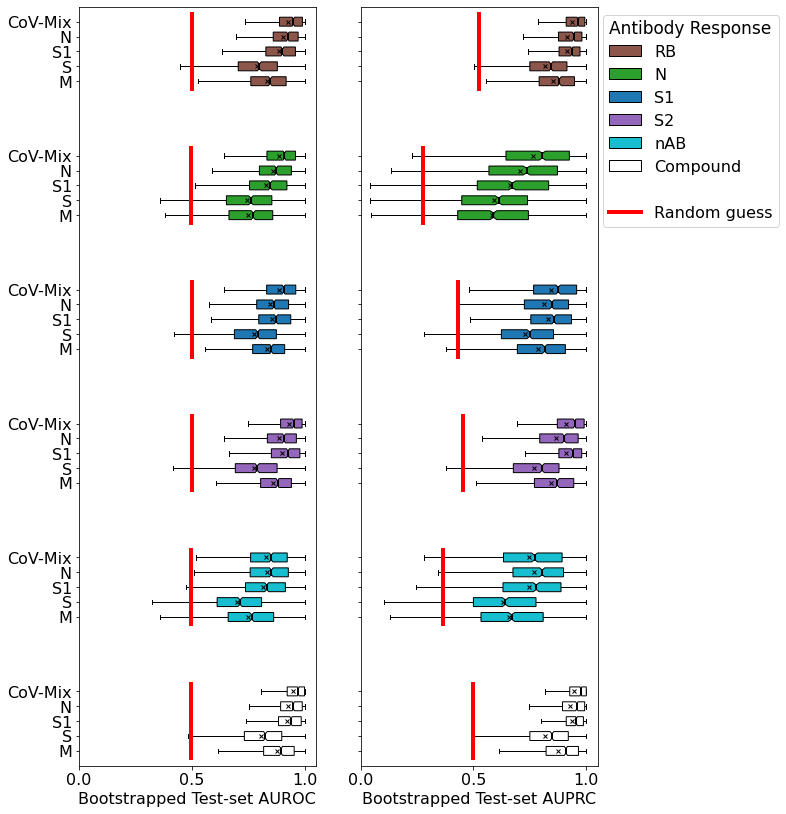

In [66]:
from matplotlib.lines import Line2D

np.random.seed(42)

# Load precomputed AUROCs
aurocs_rbd = np.stack((metrics_proba_cov2mix_rbd[:, 0], metrics_proba_n_rbd[:, 0], metrics_proba_s1_rbd[:, 0], 
                       metrics_proba_s_rbd[:, 0], metrics_proba_m_rbd[:, 0]), axis=1)

aurocs_n = np.stack((metrics_proba_cov2mix_n[:, 0], metrics_proba_n_n[:, 0], metrics_proba_s1_n[:, 0], 
                     metrics_proba_s_n[:, 0], metrics_proba_m_n[:, 0]), axis=1)
aurocs_n_replace = np.tile(np.nanmean(aurocs_n, axis=0), reps=(aurocs_n.shape[0], 1))
aurocs_n[np.isnan(aurocs_n)] = aurocs_n_replace[np.isnan(aurocs_n)]

aurocs_s1 = np.stack((metrics_proba_cov2mix_s1[:, 0], metrics_proba_n_s1[:, 0], metrics_proba_s1_s1[:, 0], 
                      metrics_proba_s_s1[:, 0], metrics_proba_m_s1[:, 0]), axis=1)

aurocs_s2 = np.stack((metrics_proba_cov2mix_s2[:, 0], metrics_proba_n_s2[:, 0], metrics_proba_s1_s2[:, 0], 
                      metrics_proba_s_s2[:, 0], metrics_proba_m_s2[:, 0]), axis=1)

aurocs_nab = np.stack((metrics_proba_cov2mix_nab[:, 0], metrics_proba_n_nab[:, 0], metrics_proba_s1_nab[:, 0], 
                       metrics_proba_s_nab[:, 0], metrics_proba_m_nab[:, 0]), axis=1)
aurocs_nab_replace = np.tile(np.nanmean(aurocs_nab, axis=0), reps=(aurocs_nab.shape[0], 1))
aurocs_nab[np.isnan(aurocs_nab)] = aurocs_nab_replace[np.isnan(aurocs_nab)]

aurocs_cons = np.stack((metrics_proba_cov2mix_cons[:, 0], metrics_proba_n_cons[:, 0], metrics_proba_s1_cons[:, 0], 
                       metrics_proba_s_cons[:, 0], metrics_proba_m_cons[:, 0]), axis=1)


# Load precomputed AUPRCs
auprcs_rbd = np.stack((metrics_proba_cov2mix_rbd[:, 1], metrics_proba_n_rbd[:, 1], metrics_proba_s1_rbd[:, 1], 
                       metrics_proba_s_rbd[:, 1], metrics_proba_m_rbd[:, 1]), axis=1)

auprcs_n = np.stack((metrics_proba_cov2mix_n[:, 1], metrics_proba_n_n[:, 1], metrics_proba_s1_n[:, 1], 
                     metrics_proba_s_n[:, 1], metrics_proba_m_n[:, 1]), axis=1)
auprcs_n_replace = np.tile(np.nanmean(auprcs_n, axis=0), reps=(auprcs_n.shape[0], 1))
auprcs_n[np.isnan(auprcs_n)] = auprcs_n_replace[np.isnan(auprcs_n)]

auprcs_s1 = np.stack((metrics_proba_cov2mix_s1[:, 1], metrics_proba_n_s1[:, 1], metrics_proba_s1_s1[:, 1], 
                      metrics_proba_s_s1[:, 1], metrics_proba_m_s1[:, 1]), axis=1)

auprcs_s2 = np.stack((metrics_proba_cov2mix_s2[:, 1], metrics_proba_n_s2[:, 1], metrics_proba_s1_s2[:, 1], 
                      metrics_proba_s_s2[:, 1], metrics_proba_m_s2[:, 1]), axis=1)

auprcs_nab = np.stack((metrics_proba_cov2mix_nab[:, 1], metrics_proba_n_nab[:, 1], metrics_proba_s1_nab[:, 1], 
                       metrics_proba_s_nab[:, 1], metrics_proba_m_nab[:, 1]), axis=1)
auprcs_nab_replace = np.tile(np.nanmean(auprcs_nab, axis=0), reps=(auprcs_nab.shape[0], 1))
auprcs_nab[np.isnan(auprcs_nab)] = auprcs_nab_replace[np.isnan(auprcs_nab)]

auprcs_cons = np.stack((metrics_proba_cov2mix_cons[:, 1], metrics_proba_n_cons[:, 1], metrics_proba_s1_cons[:, 1], 
                       metrics_proba_s_cons[:, 1], metrics_proba_m_cons[:, 1]), axis=1)

# Plotting setup
plotting_setup(16)
fig, ax = plt.subplots(1, 2, figsize=(12.5, 12))
medianprops = dict(linestyle='-', linewidth=2, color='black')
meanpointprops = dict(marker='x', markeredgecolor='black', markerfacecolor='black', markersize=4)


# Plot AUROCs
bx_rbd = ax[0].boxplot(aurocs_rbd, positions=[-4.5, -5.0, -5.5, -6.0, -6.5], showfliers=False, 
                       labels=['CoV-Mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:brown' for i in range(7)]
for patch, color in zip(bx_rbd['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_rbd[:, 0]), np.nanmean(metrics_proba_r_rbd[:, 0])], [-6.75, -4.25], 
           c='red', linewidth=4)


bx_n = ax[0].boxplot(aurocs_n, positions=[-9.0, -9.5, -10.0, -10.5, -11.0], showfliers=False, 
                     labels=['CoV-Mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                     showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:green' for i in range(7)]
for patch, color in zip(bx_n['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_n[:, 0]), np.nanmean(metrics_proba_r_n[:, 0])], [-8.75, -11.25], 
           c='red', linewidth=4)
    
bx_s1 = ax[0].boxplot(aurocs_s1, positions=[-13.5, -14.0, -14.5, -15.0, -15.5], showfliers=False, 
                      labels=['CoV-Mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False,
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:blue' for i in range(7)]
for patch, color in zip(bx_s1['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_s1[:, 0]), np.nanmean(metrics_proba_r_s1[:, 0])], [-13.25, -15.75], 
           c='red', linewidth=4)
    
bx_s2 = ax[0].boxplot(aurocs_s2, positions=[-18.0, -18.5, -19.0, -19.5, -20.0], showfliers=False, 
                      labels=['CoV-Mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:purple' for i in range(7)]
for patch, color in zip(bx_s2['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_s2[:, 0]), np.nanmean(metrics_proba_r_s2[:, 0])], [-17.75, -20.25], 
           c='red', linewidth=4)
    
bx_nab = ax[0].boxplot(aurocs_nab, positions=[-22.5, -23.0, -23.5, -24.0, -24.5], showfliers=False, 
                     labels=['CoV-Mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False,
                     showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:cyan' for i in range(7)]
for patch, color in zip(bx_nab['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_nab[:, 0]), np.nanmean(metrics_proba_r_nab[:, 0])], [-22.25, -24.75], 
         c='red', linewidth=4)
    
bx_cons = ax[0].boxplot(aurocs_cons, positions=[-27.0, -27.5, -28.0, -28.5, -29.0], showfliers=False, 
                      labels=['CoV-Mix', 'N', 'S1', 'S', 'M'], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['white' for i in range(7)]
for patch, color in zip(bx_cons['boxes'], colors):
    patch.set_facecolor(color)
ax[0].plot([np.nanmean(metrics_proba_r_cons[:, 0]), np.nanmean(metrics_proba_r_cons[:, 0])], [-26.75, -29.25], 
         c='red', linewidth=4)
    
ax[0].set_xlabel('Bootstrapped Test-set AUROC')

ax[0].set_xlim([0, 1.05])


# Plot AUPRCs
bx_rbd = ax[1].boxplot(auprcs_rbd, positions=[-4.5, -5.0, -5.5, -6.0, -6.5], showfliers=False, 
                       labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False, 
                       showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:brown' for i in range(7)]
for patch, color in zip(bx_rbd['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_rbd[:, 1]), np.nanmean(metrics_proba_r_rbd[:, 1])], [-6.75, -4.25], 
           c='red', linewidth=4)


bx_n = ax[1].boxplot(auprcs_n, positions=[-9.0, -9.5, -10.0, -10.5, -11.0], showfliers=False, 
                     labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False,
                     showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:green' for i in range(7)]
for patch, color in zip(bx_n['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_n[:, 1]), np.nanmean(metrics_proba_r_n[:, 1])], [-8.75, -11.25], 
           c='red', linewidth=4)
    
bx_s1 = ax[1].boxplot(auprcs_s1, positions=[-13.5, -14.0, -14.5, -15.0, -15.5], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False,
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:blue' for i in range(7)]
for patch, color in zip(bx_s1['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_s1[:, 1]), np.nanmean(metrics_proba_r_s1[:, 1])], [-13.25, -15.75], 
         c='red', linewidth=4)
    
bx_s2 = ax[1].boxplot(auprcs_s2, positions=[-18.0, -18.5, -19.0, -19.5, -20.0], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:purple' for i in range(7)]
for patch, color in zip(bx_s2['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_s2[:, 1]), np.nanmean(metrics_proba_r_s2[:, 1])], [-17.75, -20.25], 
           c='red', linewidth=4)
    
bx_nab = ax[1].boxplot(auprcs_nab, positions=[-22.5, -23.0, -23.5, -24.0, -24.5], showfliers=False, 
                     labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False,
                     showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['tab:cyan' for i in range(7)]
for patch, color in zip(bx_nab['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_nab[:, 1]), np.nanmean(metrics_proba_r_nab[:, 1])], [-22.25, -24.75], 
         c='red', linewidth=4)
    
bx_cons = ax[1].boxplot(auprcs_cons, positions=[-27.0, -27.5, -28.0, -28.5, -29.0], showfliers=False, 
                      labels=['', '', '', '', ''], notch=True, patch_artist=True, vert=False, 
                      showmeans=True, medianprops=medianprops, meanprops=meanpointprops) 
colors = ['white' for i in range(7)]
for patch, color in zip(bx_cons['boxes'], colors):
    patch.set_facecolor(color)
ax[1].plot([np.nanmean(metrics_proba_r_cons[:, 1]), np.nanmean(metrics_proba_r_cons[:, 1])], [-26.75, -29.25], 
         c='red', linewidth=4)
    
ax[1].legend(['Antibody Response', bx_rbd["boxes"][0], bx_n["boxes"][0], bx_s1["boxes"][0], 
              bx_s2["boxes"][0], bx_nab["boxes"][0], bx_cons["boxes"][0], '', 
              Line2D([0], [0], color='red', lw=4)], 
             ['', 'RB', 'N', 'S1', 'S2', 'nAB', 'Compound', '', 'Random guess'], 
             handler_map={'Antibody Response': LegendTitle({'fontsize': 17}),
                         '': LegendTitle({'fontsize': 17})},
             loc='upper right',  bbox_to_anchor=(1.8, 1))
    
ax[1].set_xlabel('Bootstrapped Test-set AUPRC')

ax[1].set_xlim([0, 1.05])


plt.tight_layout(pad=2.0)

plt.savefig(fname="figures/antibody_boxplots.svg", dpi=300, bbox_inches='tight')
plt.savefig(fname="figures/antibody_boxplots.pdf", dpi=300, bbox_inches='tight')

## Assessing Associations between T-cell Data and Symptoms Score

In [67]:
# Data
rdata = df_included.values
rdata_cols = list(df_included.columns)
ndata, ndata_cols = construct_tcell_df(df_included, feature_type='', scale=False)
ndata_mfi, ndata_mfi_cols = construct_mfi_df(df_included, scale=False)

In [68]:
# Compund symptoms score
symptoms_score_S10 = np.squeeze(
    rdata[:, np.argwhere(np.array(rdata_cols) == 'symptoms_score_S10')[0]].astype(np.float64))
symptoms_score_S10[np.isnan(symptoms_score_S10)] = 0
symptoms_score_S11 = np.squeeze(
    rdata[:, np.argwhere(np.array(rdata_cols) == 'symptoms_score_S11')[0]].astype(np.float64))
symptoms_score_S11[np.isnan(symptoms_score_S11)] = 0
symptoms_score_compound = np.maximum(symptoms_score_S10, symptoms_score_S11)

In [69]:
# Some important features
CD4_IL2_CD154_S10 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IL2_pos_CD154_pos_perc_2_S10')[0]].astype(np.float64))
CD4_IL2_CD154_S11 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IL2_pos_CD154_pos_perc_2_S11')[0]].astype(np.float64))
CD4_IFN_TNF_S10 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IFN_pos_TNF_pos_perc_3_S10')[0]].astype(np.float64))
CD4_IFN_TNF_S11 = np.squeeze(
    ndata[:, np.argwhere(ndata_cols == 'CD4.IFN_pos_TNF_pos_perc_3_S11')[0]].astype(np.float64))

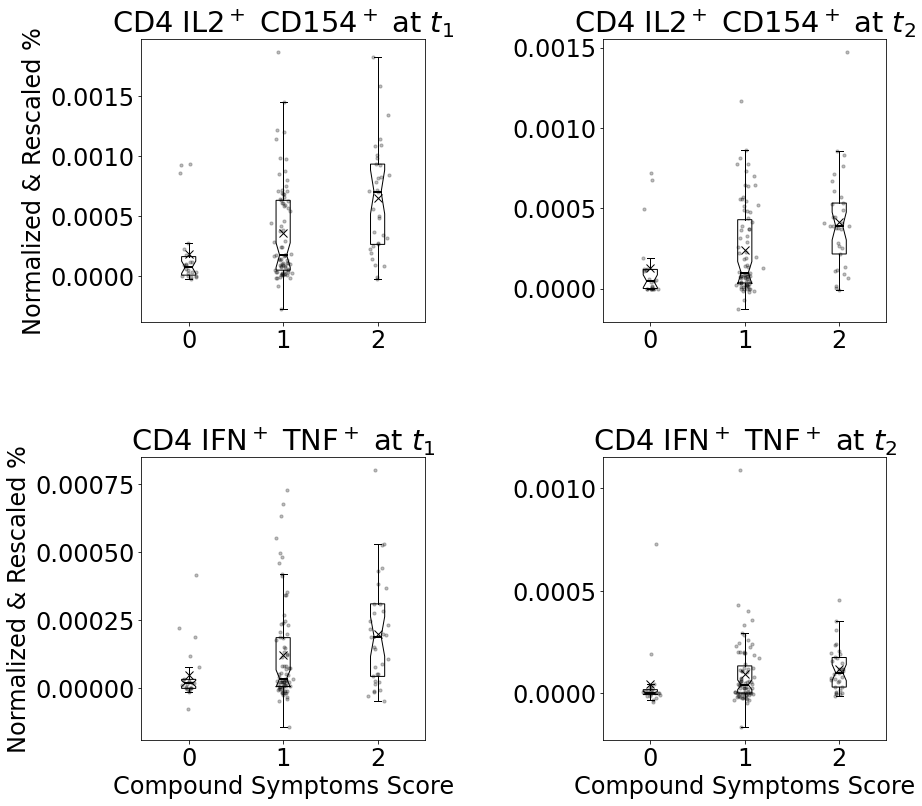

In [72]:
# Percentages vs. symptoms scores
np.random.seed(42)

plotting_setup(24)
fig, ax = plt.subplots(2, 2, figsize=(14, 13))
medianprops = dict(linestyle='-', linewidth=2, color='black')
meanpointprops = dict(marker='x', markeredgecolor='black', markerfacecolor='black', markersize=8)


scores = np.unique(symptoms_score_compound)
cnt = 0
for s in scores:
    bx_s = ax[0, 0].boxplot(CD4_IL2_CD154_S10[symptoms_score_compound == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IL2_CD154_S10[symptoms_score_compound == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IL2_CD154_S10[symptoms_score_compound == s].shape[0], ))
    ax[0, 0].scatter(xs, CD4_IL2_CD154_S10[symptoms_score_compound == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[0, 0].set_title('CD4 IL2$^+$ CD154$^+$ at $t_1$')
ax[0, 0].set_ylabel('Normalized & Rescaled %')


scores = np.unique(symptoms_score_compound)
cnt = 0
for s in scores:
    bx_s = ax[0, 1].boxplot(CD4_IL2_CD154_S11[symptoms_score_compound == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IL2_CD154_S11[symptoms_score_compound == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IL2_CD154_S11[symptoms_score_compound == s].shape[0], ))
    ax[0, 1].scatter(xs, CD4_IL2_CD154_S11[symptoms_score_compound == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[0, 1].set_title('CD4 IL2$^+$ CD154$^+$ at $t_2$')


scores = np.unique(symptoms_score_compound)
cnt = 0
for s in scores:
    bx_s = ax[1, 0].boxplot(CD4_IFN_TNF_S10[symptoms_score_compound == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IFN_TNF_S10[symptoms_score_compound == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IFN_TNF_S10[symptoms_score_compound == s].shape[0], ))
    ax[1, 0].scatter(xs, CD4_IFN_TNF_S10[symptoms_score_compound == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[1, 0].set_title('CD4 IFN$^+$ TNF$^+$ at $t_1$')
ax[1, 0].set_xlabel('Compound Symptoms Score')
ax[1, 0].set_ylabel('Normalized & Rescaled %')


scores = np.unique(symptoms_score_compound)
cnt = 0
for s in scores:
    bx_s = ax[1, 1].boxplot(CD4_IFN_TNF_S11[symptoms_score_compound == s], positions=[cnt], 
                            showfliers=False, labels=['' + str(int(s))], notch=True, patch_artist=True, 
                            vert=True, showmeans=True, medianprops=medianprops, meanprops=meanpointprops)
    colors = ['n']
    for patch, color in zip(bx_s['boxes'], colors):
        patch.set_facecolor((0.1, 0.2, 0.5, 0.0))

    xs = np.ones_like(CD4_IFN_TNF_S11[symptoms_score_compound == s]) * cnt
    xs = xs + np.random.normal(loc=0, scale=0.05, 
                               size=(CD4_IFN_TNF_S11[symptoms_score_compound == s].shape[0], ))
    ax[1, 1].scatter(xs, CD4_IFN_TNF_S11[symptoms_score_compound == s], color='black', alpha=0.25, s=10)

    cnt = cnt + 1

ax[1, 1].set_title('CD4 IFN$^+$ TNF$^+$ at $t_2$')
ax[1, 1].set_xlabel('Compound Symptoms Score')

plt.tight_layout(pad=3.0)

plt.savefig(fname="figures/symptoms_score_boxplots.svg", dpi=300, bbox_inches='tight')
plt.savefig(fname="figures/symptoms_score_boxplots.pdf", dpi=300, bbox_inches='tight')

In [73]:
# Predictive model
metrics_clf_symp, metrics_proba_symp, feature_importances_symp = boot_train_test_XGB(
    X=ndata, y=symptoms_score_compound, metrics_clf=[balanced_accuracy_score], 
    metrics_proba=[roc_auc_score], B=1000, verbose=False)

/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/local/home/anaconda3/envs/t-cells-cov/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains

In [74]:
print_perf_statistics(metrics_clf_symp, alpha=0.05)

0.358; [0.167, 0.658]


In [75]:
print_perf_statistics(metrics_proba_symp, alpha=0.05)

0.521; [0.265, 0.78]


## Antibody Response Prediction: Normalising by Dividing by Background

### Counts

In [76]:
# LR
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
disease_status = compound_response
disease_status = ((disease_status == 'positive') * 1.).astype(int)

metrics_clf_c_lr, metrics_proba_c_lr, feature_importances_c_lr = boot_train_test_LR(
    X=df_tcell_c, y=disease_status, 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [77]:
print_perf_statistics(metrics_clf_c_lr, alpha=0.05)

0.788; [0.537, 0.969]
0.785; [0.429, 1.0]
0.791; [0.444, 1.0]


In [78]:
print_perf_statistics(metrics_proba_c_lr, alpha=0.05)

0.861; [0.615, 1.0]
0.854; [0.538, 1.0]


In [79]:
# XGBoost
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
disease_status = compound_response
disease_status = ((disease_status == 'positive') * 1.).astype(int)

metrics_clf_c, metrics_proba_c, feature_importances_c = boot_train_test_XGB(
    X=df_tcell_c, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=False)

In [80]:
print_perf_statistics(metrics_clf_c, alpha=0.05)

0.84; [0.615, 1.0]
0.842; [0.5, 1.0]
0.838; [0.5, 1.0]


In [81]:
print_perf_statistics(metrics_proba_c, alpha=0.05)

0.92; [0.726, 1.0]
0.925; [0.687, 1.0]


### Percentages

In [82]:
# LR
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
disease_status = compound_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_p_lr, metrics_proba_p_lr, feature_importances_p_lr = boot_train_test_LR(
    X=df_tcell_p, y=disease_status, 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [83]:
print_perf_statistics(metrics_clf_p_lr, alpha=0.05)

0.824; [0.597, 1.0]
0.82; [0.455, 1.0]
0.828; [0.5, 1.0]


In [84]:
print_perf_statistics(metrics_proba_p_lr, alpha=0.05)

0.905; [0.673, 1.0]
0.909; [0.668, 1.0]


In [85]:
# XGBoost
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
disease_status = compound_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_p, metrics_proba_p, feature_importances_p = boot_train_test_XGB(
    X=df_tcell_p, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=False)

In [86]:
print_perf_statistics(metrics_clf_p, alpha=0.05)

0.841; [0.634, 1.0]
0.836; [0.533, 1.0]
0.846; [0.5, 1.0]


In [87]:
print_perf_statistics(metrics_proba_p, alpha=0.05)

0.915; [0.732, 1.0]
0.918; [0.674, 1.0]


### Counts & Percentages

In [88]:
# LR
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
disease_status = compound_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_pc_lr, metrics_proba_pc_lr, feature_importances_pc_lr = boot_train_test_LR(
    X=df_tcell_pc, y=disease_status, 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [89]:
print_perf_statistics(metrics_clf_pc_lr, alpha=0.05)

0.81; [0.583, 1.0]
0.821; [0.461, 1.0]
0.799; [0.462, 1.0]


In [90]:
print_perf_statistics(metrics_proba_pc_lr, alpha=0.05)

0.89; [0.645, 1.0]
0.884; [0.581, 1.0]


In [91]:
# XGBoost
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
df_tcell_pc = np.concatenate((df_tcell_p, df_tcell_c), axis=1)
feature_names_pc = np.concatenate((feature_names_p, feature_names_c))
disease_status = compound_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_pc, metrics_proba_pc, feature_importances_pc = boot_train_test_XGB(
    X=df_tcell_pc, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [92]:
print_perf_statistics(metrics_clf_pc, alpha=0.05)

0.849; [0.623, 1.0]
0.845; [0.5, 1.0]
0.853; [0.5, 1.0]


In [93]:
print_perf_statistics(metrics_proba_pc, alpha=0.05)

0.925; [0.733, 1.0]
0.93; [0.718, 1.0]


### MFIs

In [94]:
# LR
df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included, norm_type='ratio')
disease_status = compound_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_mfi_lr, metrics_proba_mfi_lr, feature_importances_mfi_lr = boot_train_test_LR(
    X=df_tcell_mfi, y=disease_status, 
    metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [95]:
print_perf_statistics(metrics_clf_mfi_lr, alpha=0.05)

0.708; [0.448, 0.932]
0.68; [0.3, 1.0]
0.737; [0.389, 1.0]


In [96]:
print_perf_statistics(metrics_proba_mfi_lr, alpha=0.05)

0.776; [0.471, 0.989]
0.792; [0.461, 0.992]


In [97]:
# XGBoost
df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included, norm_type='ratio')
disease_status = compound_response
disease_status = ((disease_status == "positive") * 1.0).astype(int)

metrics_clf_mfi, metrics_proba_mfi, feature_importances_mfi = boot_train_test_XGB(
    X=df_tcell_mfi, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [98]:
print_perf_statistics(metrics_clf_mfi, alpha=0.05)

0.843; [0.623, 1.0]
0.829; [0.5, 1.0]
0.856; [0.5, 1.0]


In [99]:
print_perf_statistics(metrics_proba_mfi, alpha=0.05)

0.916; [0.721, 1.0]
0.92; [0.682, 1.0]
